### Loading Quantinuum Hardware


In [ ]:
#%pip install pytket

In [1]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-1'

backend = QuantinuumBackend(device_name = machine)
backend.login()

In [2]:
print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1 status:  in maintenance


List all the available devices

In [3]:
[x.device_name for x in QuantinuumBackend.available_devices()]

['H1-1SC', 'H1-1E', 'H1-1']

#### How to change the backend?

In [4]:
machine = 'H1-1E'
n_shots = 100
max_batch_cost = 100

backend = QuantinuumBackend(device_name = machine)

### Quantinuum TKET Workshop

#### Introduction to Quantum Software and TKET


 System Software
<li> Compiler  - TKET , Qiskit
<li> Online Service - AWS Braket, Azure quantum
<li> Quantum Error Correction - Qermit
<li> Quantum Programming Language - Q#, Silq, quipper

Quantum Hardware

<li> Trapped Ions - Quantinuum, IONQ, AQT
<li> Superconductors - IBM, Google , Rigetti, IQM
<li> Photonics - PsiQuantum, Quandela
<li> Neutral Atoms - Pasqal, Infleqtion
<li> Others - Semiconductors, Topological Qubits

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Making the circuit

Let's build a basic **Bell Circuit**

First we'll make the circuit and then add the gates sequentially.



In [14]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter # necessary to visualize circuits in Jupyter

In [15]:
# let's create a Bell state
Bell = Circuit(2, 2, name="Bell")
Bell.H(0) # Hadamard gate on qubit 0
Bell.CX(0, 1) # CNOT gate on control qubit 0 and target qubit 1
render_circuit_jupyter(Bell) # visualize the circuit

Let's run it on `AerStateBackend`

In [16]:
from pytket.extensions.qiskit import AerStateBackend # import the backend to simulate the circuit

sv_backend = AerStateBackend() # initialize the backend
sv_result = sv_backend.run_circuit(Bell,n_shots= 100).get_state() # run the circuit

print("The statevector is :",sv_result) # print the statevector

The statevector is : [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


which is basically this 

$ \begin{equation}
|\psi \rangle = \frac{1}{\sqrt{2}} \big(|00 \rangle + | 11 \rangle  \big)\,, \qquad \frac{1}{\sqrt{2}} \approx 0.707...
\end{equation}$

Let's see the counts

In [17]:
from pytket.extensions.qiskit import AerBackend # import the backend to simulate the circuit

# we need to measure first
Bell.measure_all()
render_circuit_jupyter(Bell) # visualize the circuit


backend = AerBackend() # initialize the backend
result = backend.run_circuit(Bell,n_shots= 100).get_counts() # run the circuit
print("The result is :",result) # print the result

The result is : Counter({(1, 1): 54, (0, 0): 46})


#### Plotting

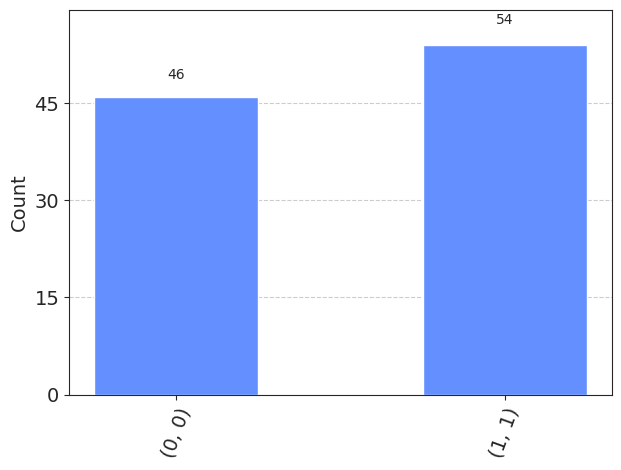

In [20]:
# from plotting import plot_results # import the function to plot the results 
'''
plot_results do not work from plotting, so use plot_histogram from qiskit.tools.visualization

'''
from qiskit.tools.visualization import plot_histogram
plot_histogram(result) # plot the results

Adding simple gates is easy in `pytket`, but somegates need to be accessed through teh `OpType`, where angles are specified as the number of half turns.

>All parametrised OpTypes which take angles (e.g. Rz, CPhase, FSim) expect parameters in multiples of pi (half-turns). This may differ from other quantum programming tools you have used, which have specified angles in radians, or perhaps even degrees. Therefore, for instance circuit.add_gate(OpType.Rx, 1, [0]) is equivalent in terms of the unitary to circuit.add_gate(OpType.X, [0])

Let's learn about this by making a **Quantum Fourier Transform Circuit**

This circuit is a very important subroutine in many algorithms including **Shor's algorithms**



To make an $n$ qubit QFT, we need $n$ Hadamard gate (one for each qubit), $n/2$ SWAP gates, and a $n(n-1)/2$ controlled unitary rotations
 $$ \begin{equation}
\text{CU1} = 
\begin{pmatrix}
I & 0 \\
0 & \text{U1}
\end{pmatrix}
\,, \quad 
\text{U1} = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \pi \theta}
\end{pmatrix}
\end{equation}$$


rotation is done by smaller and smaller angles of $\theta = \frac{1}{2^{n-1}}$

In [21]:
# let's build a QFT circuit for 3 qubits

from pytket.circuit import Qubit, Bit, Circuit, OpType

qft = Circuit(3, name="QFT")

# add the hadamard, which is done simply
qft.H(0)
## adding the controlled rotations is a bit more involved

qft.add_gate(OpType.CU1, [0.5],[1,0])

# circuit.add_gate(OpType.gate, [number of rotations], [control qubit, target qubit])
qft.add_gate(OpType.CU1, [0.25],[2,0])

# another one

qft.H(1)
qft.add_gate(OpType.CU1,[0.5],[2,1])
qft.H(2)

# and a final swap

qft.SWAP(0,2)

# let's see what we have

render_circuit_jupyter(qft)

Let's build a **QFT** Circuit for `n` qubits

In [22]:
def qft_circuit(n):
    qft = Circuit(n, name="QFT")
    for i in range(n):
        qft.H(i)
        for j in range(i+1,n):
            qft.add_gate(OpType.CU1, [2**-(j-i)],[j,i])
    for i in range(n//2):
        qft.SWAP(i,n-i-1)
    return qft

In [24]:
render_circuit_jupyter(qft_circuit(4))